In [1]:
import os
import torch
import torchvision 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=8
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [2]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", 
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        # print(x.shape)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2),negative_slope=0.2)
        x = F.leaky_relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2),negative_slope=0.2)
        # print(x.shape)
        x = x.view(-1, 320)
        x = F.leaky_relu(self.fc1(x),negative_slope=0.2)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)
        self.conv = nn.Conv2d(16, 1, kernel_size=7)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)
        
        x = self.ct1(x)
        x = F.relu(x)
        
        x = self.ct2(x)
        x = F.relu(x)
        
        return self.conv(x)

In [5]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        self.automatic_optimization = False

        # random noise
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)


    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch

        # Sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim).type_as(real_imgs)

        # Access optimizers
        opt_g, opt_d = self.optimizers()

        # Train generator: maximize log(D(G(z)))
        fake_imgs = self(z)
        y_hat = self.discriminator(fake_imgs)
        y = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        g_loss = self.adversarial_loss(y_hat, y)

        # Optimize generator
        self.manual_backward(g_loss)
        opt_g.step()
        opt_g.zero_grad()

        # Log generator loss
        self.log("g_loss", g_loss, prog_bar=True)

        # Train discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        y_hat_real = self.discriminator(real_imgs)
        y_real = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        real_loss = self.adversarial_loss(y_hat_real, y_real)

        y_hat_fake = self.discriminator(fake_imgs.detach())
        y_fake = torch.zeros(real_imgs.size(0), 1).type_as(real_imgs)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        d_loss = (real_loss + fake_loss) / 2

        # Optimize discriminator
        self.manual_backward(d_loss)
        opt_d.step()
        opt_d.zero_grad()

        # Log discriminator loss
        self.log("d_loss", d_loss, prog_bar=True, on_epoch=True)

        return None 



    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []

    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print('epoch ', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i + 1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap='gray_r', interpolation='none')
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()

    def on_train_epoch_end(self):
        self.plot_imgs()
        self.log("epoch", self.current_epoch)
        print(f"Epoch {self.current_epoch}: g_loss = {self.trainer.logged_metrics.get('g_loss', 'N/A')}, d_loss = {self.trainer.logged_metrics.get('d_loss', 'N/A')}")


    def on_validation_epoch_end(self):
        self.plot_imgs()
        self.log("epoch", self.current_epoch)


In [6]:
dm = MNISTDataModule()
model = GAN()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/mw/miniconda3/envs/sih/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/mw/miniconda3/envs/sih/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read ht

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ generator     │ Generator     │  358 K │ train │
│ 1 │ discriminator │ Discriminator │ 21.4 K │ train │
└───┴───────────────┴───────────────┴────────┴───────┘

Trainable params: 379 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 379 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 11                                                                                          
Modules in eval mode: 0

Output()

epoch  0

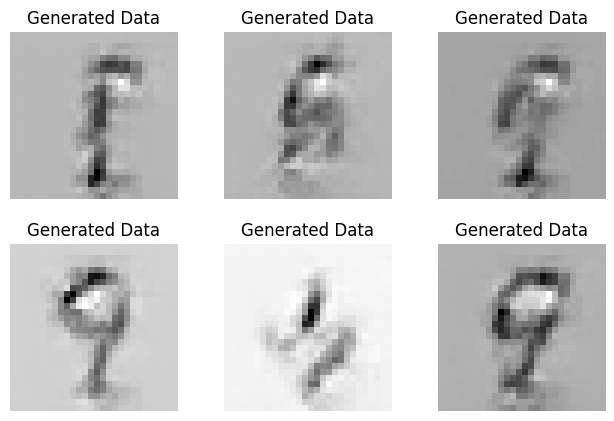

Epoch 0: g_loss = 0.2911143898963928, d_loss = N/A

epoch  1

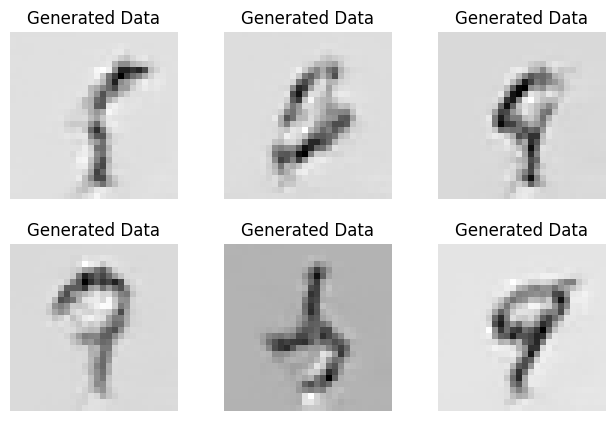

Epoch 1: g_loss = 0.40280765295028687, d_loss = N/A

epoch  2

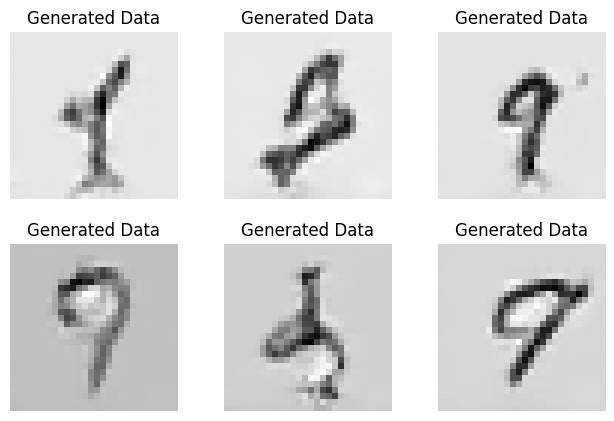

Epoch 2: g_loss = 0.3303816318511963, d_loss = N/A

epoch  3

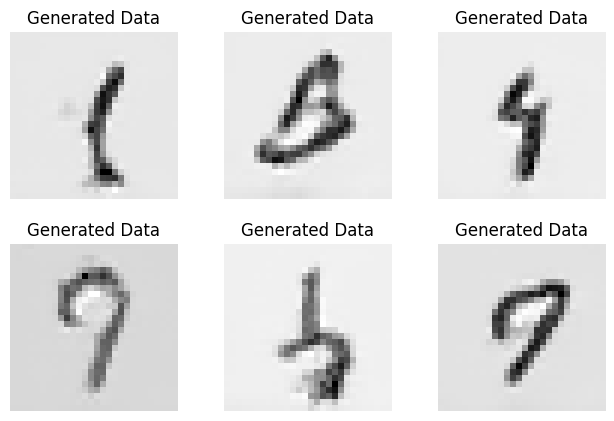

Epoch 3: g_loss = 0.424030065536499, d_loss = N/A

epoch  4

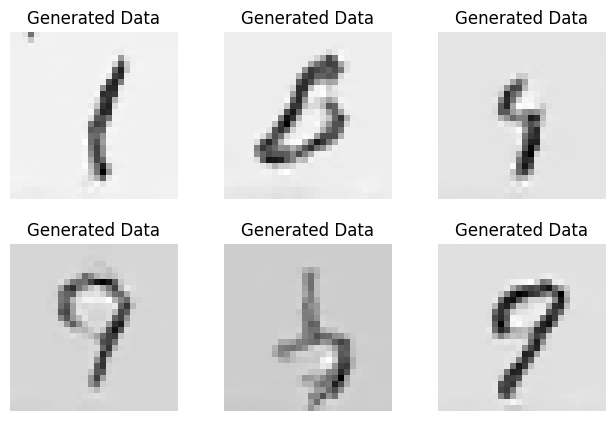

Epoch 4: g_loss = 0.3463338613510132, d_loss = N/A

epoch  5

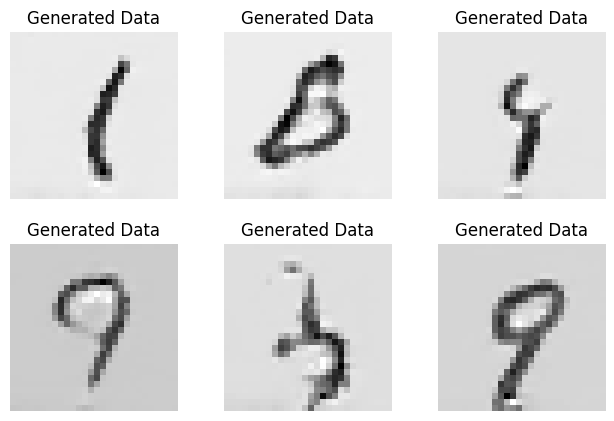

Epoch 5: g_loss = 0.3147329092025757, d_loss = N/A

epoch  6

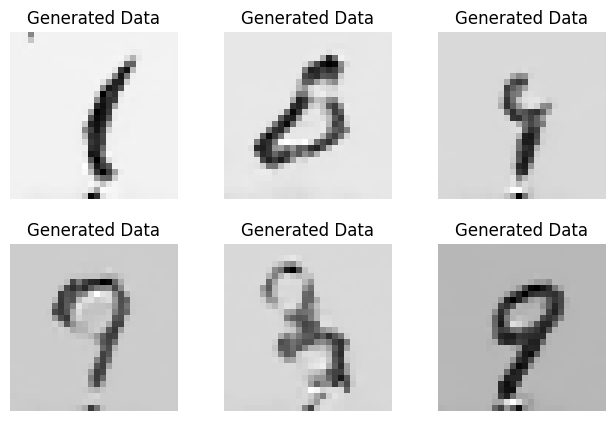

Epoch 6: g_loss = 0.31149834394454956, d_loss = N/A

epoch  7

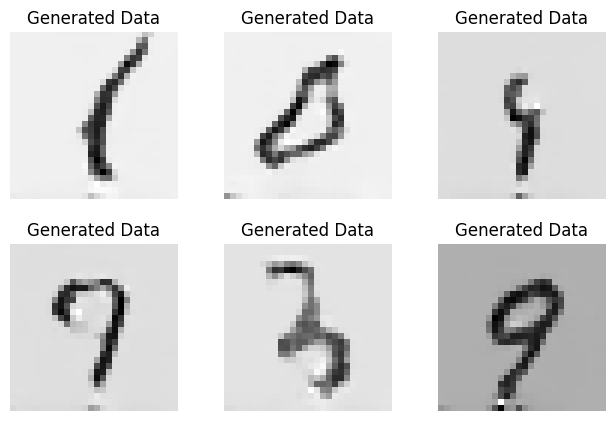

Epoch 7: g_loss = 0.3427630066871643, d_loss = N/A

epoch  8

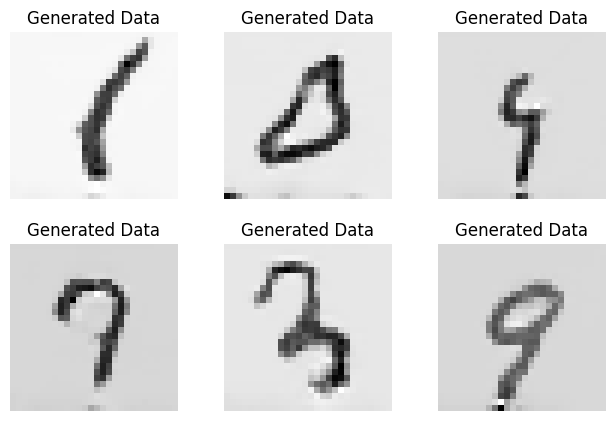

Epoch 8: g_loss = 0.2945154905319214, d_loss = N/A

epoch  9

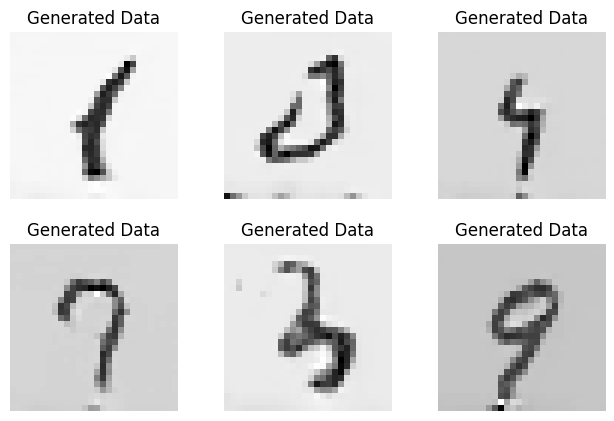

Epoch 9: g_loss = 0.27769553661346436, d_loss = N/A

epoch  10

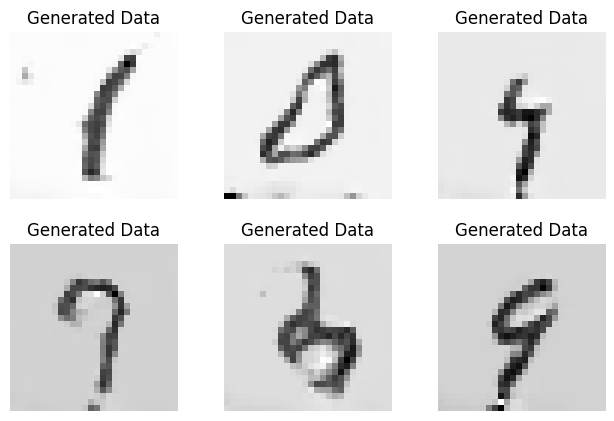

Epoch 10: g_loss = 0.3151448667049408, d_loss = N/A

epoch  11

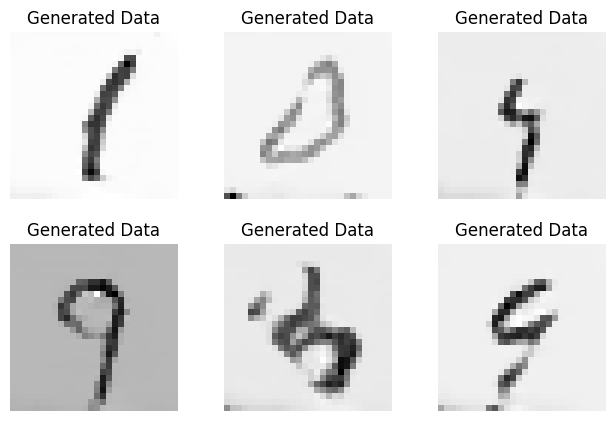

Epoch 11: g_loss = 0.32429713010787964, d_loss = N/A

epoch  12

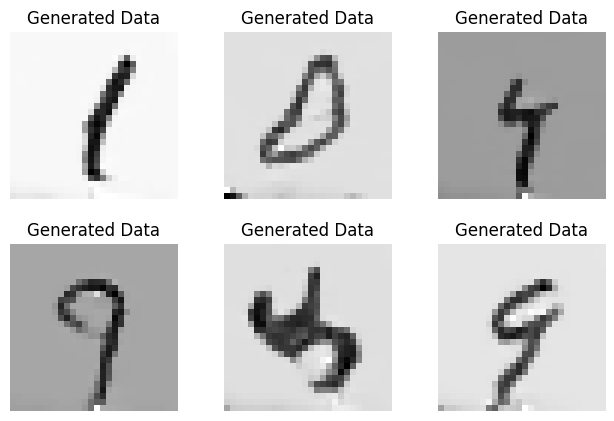

Epoch 12: g_loss = 0.28641074895858765, d_loss = N/A

epoch  13

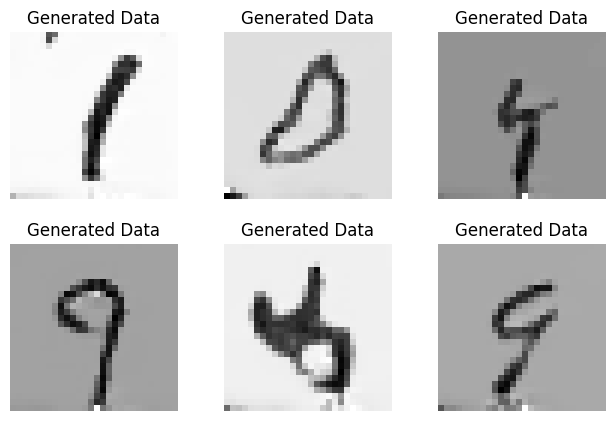

Epoch 13: g_loss = 0.28919917345046997, d_loss = N/A

epoch  14

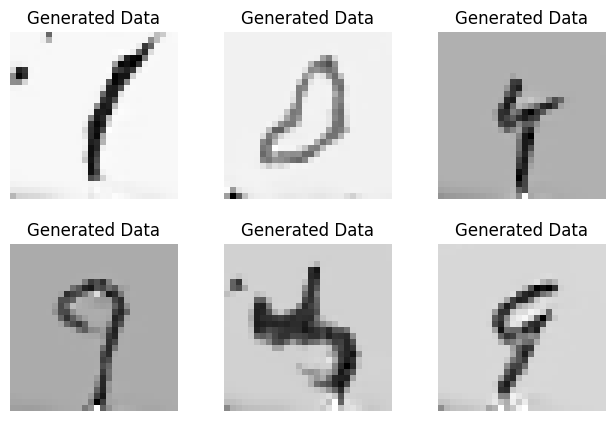

Epoch 14: g_loss = 0.3189718723297119, d_loss = N/A

epoch  15

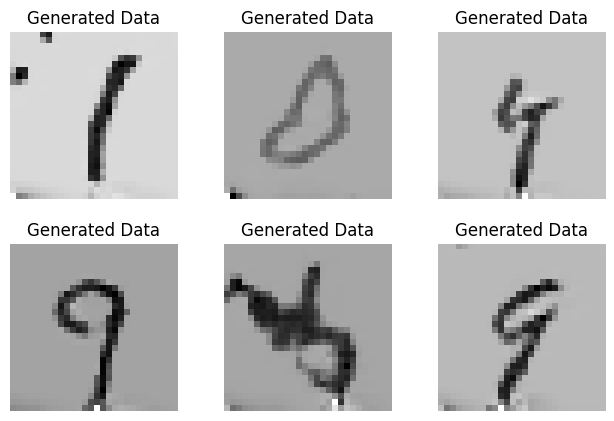

Epoch 15: g_loss = 0.34167757630348206, d_loss = N/A

epoch  16

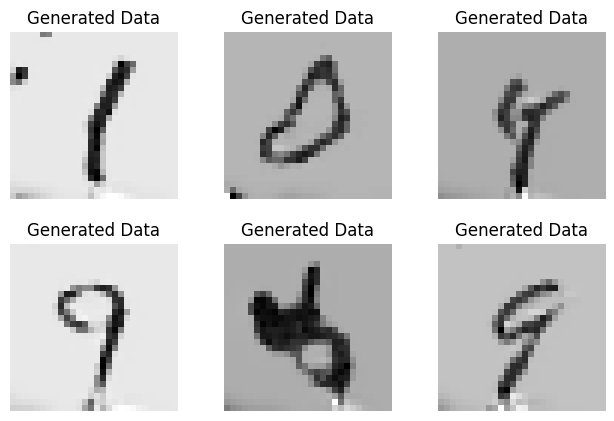

Epoch 16: g_loss = 0.36766815185546875, d_loss = N/A

epoch  17

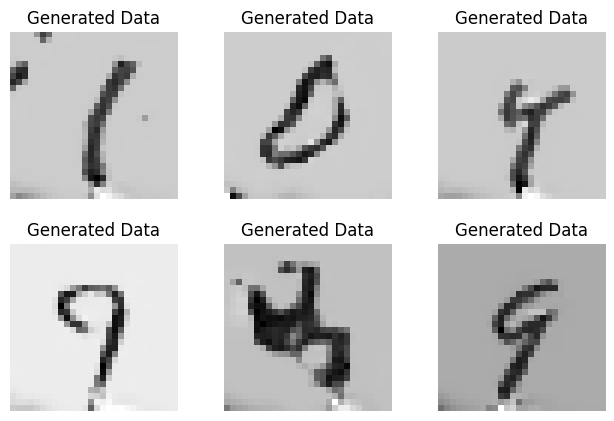

Epoch 17: g_loss = 0.3303760886192322, d_loss = N/A

epoch  18

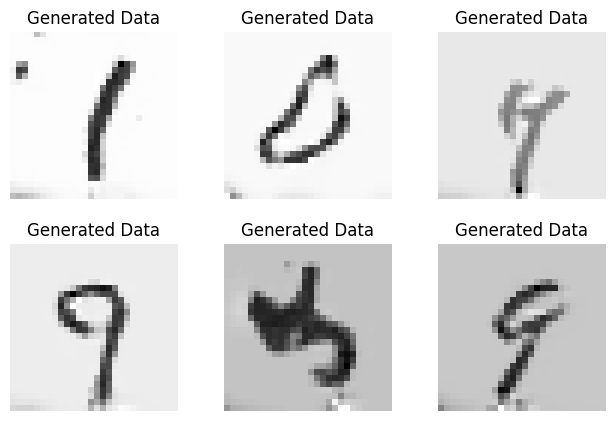

Epoch 18: g_loss = 0.2543033957481384, d_loss = N/A

epoch  19

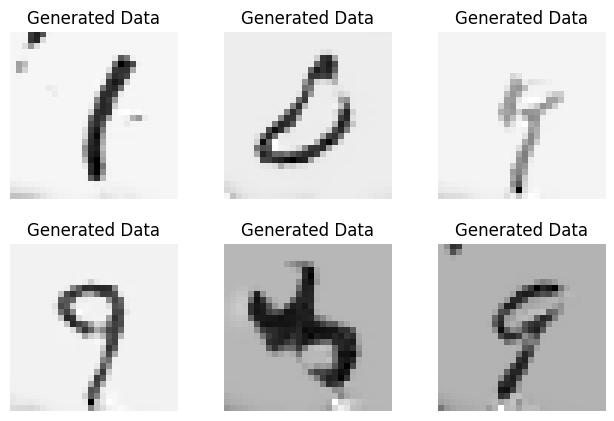

Epoch 19: g_loss = 0.29569822549819946, d_loss = N/A

`Trainer.fit` stopped: `max_epochs=20` reached.


In [7]:
from pytorch_lightning.callbacks import RichProgressBar

progress_bar = RichProgressBar()
trainer = pl.Trainer(
    max_epochs=20, 
    accelerator="gpu", 
    callbacks=[progress_bar], 
    logger=True
)
trainer.fit(model,dm)